In [1]:
# import packages
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import VGG16
from keras import applications
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Get current working directory
os.getcwd()

'/kaggle/working'

In [3]:
# Set train and test paths to data. Import training labels as a dataframe
train_dir = '../input/train/train/'
test_dir = '../input/test/test/'
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
# Download the VGG16 model that we are going to use for transfer learning
# Include_top=False means that we are not going to include the top 3 classification layers
# We are going to create our own top classification layers based on our cactus data
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [5]:
# Freeze the weights of the convolutional layers and pooling layers - we will use the pre-trained weights
base_model.trainable = False 
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [6]:
# Let us build our own classification layers on top of the existing vgg16 model
# We add two classification layers. One hidden layer with 256 neurons and relu activation function
# and the output layer with one neuron and a sigmoid activation function
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [7]:
# We set the training metrics for our upgraded model. We use binary crossentropy as the loss function
# and Adam as the optimizer. For the metric we use accuracy
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [8]:
# Prepare training images for modeling by appending them to a list and converting to np arrays
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(train_dir + img_id))    
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)

In [9]:
# Set training hyperparameters
batch_size = 32
nb_epoch = 100

In [10]:
%%time
# Train model
history = model.fit(X_tr, Y_tr,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)

Train on 15750 samples, validate on 1750 samples
Epoch 1/100
 - 8s - loss: 0.6781 - acc: 0.6018 - val_loss: 0.5095 - val_acc: 0.7463
Epoch 2/100
 - 5s - loss: 0.5040 - acc: 0.7578 - val_loss: 0.4320 - val_acc: 0.7531
Epoch 3/100
 - 5s - loss: 0.4360 - acc: 0.7884 - val_loss: 0.3745 - val_acc: 0.7960
Epoch 4/100
 - 5s - loss: 0.3826 - acc: 0.8258 - val_loss: 0.3338 - val_acc: 0.8406
Epoch 5/100
 - 5s - loss: 0.3440 - acc: 0.8511 - val_loss: 0.3012 - val_acc: 0.8840
Epoch 6/100
 - 5s - loss: 0.3118 - acc: 0.8712 - val_loss: 0.2748 - val_acc: 0.9120
Epoch 7/100
 - 5s - loss: 0.2847 - acc: 0.8867 - val_loss: 0.2529 - val_acc: 0.9269
Epoch 8/100
 - 5s - loss: 0.2655 - acc: 0.9004 - val_loss: 0.2348 - val_acc: 0.9331
Epoch 9/100
 - 5s - loss: 0.2471 - acc: 0.9105 - val_loss: 0.2201 - val_acc: 0.9400
Epoch 10/100
 - 5s - loss: 0.2308 - acc: 0.9180 - val_loss: 0.2080 - val_acc: 0.9434
Epoch 11/100
 - 5s - loss: 0.2196 - acc: 0.9234 - val_loss: 0.1981 - val_acc: 0.9457
Epoch 12/100
 - 5s - loss

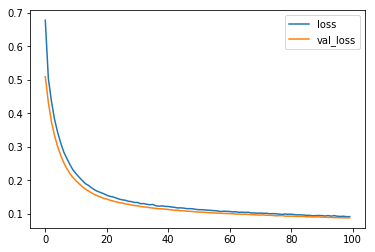

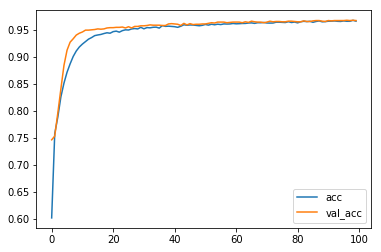

In [11]:
# clear history
with open('history.json', 'w') as f:
    json.dump(history.history, f)
    
# plot loss rate of training and validation sets
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# plot accuracy of training and validation sets
history_df[['acc', 'val_acc']].plot()

In [12]:
%%time

# load testing images into a list and form as np array to prepare for testing
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(test_dir)):
    X_tst.append(cv2.imread(test_dir + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255


CPU times: user 968 ms, sys: 812 ms, total: 1.78 s
Wall time: 6.72 s


In [13]:
# Prediction
test_predictions = model.predict(X_tst)

In [14]:
# create predictions data frame
sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])

# we predict a cactus if according to the model there is over 75% chance of there being a cactus
sub_df['has_cactus'] = sub_df['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

In [15]:
# create id column and rearrange
sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]

In [16]:
sub_df

,id,has_cactus
0,,1
1,,0
2,,1
3,,1
4,,1
5,,1
6,,1
7,,1
8,,0
9,,1


In [17]:
for i, img in enumerate(Test_imgs):
    sub_df.set_value(i,'id',img)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [18]:
sub_df.head()

,id,has_cactus
0,c662bde123f0f83b3caae0ffda237a93.jpg,1
1,9553eed7793d4cf88b5226d446d93dae.jpg,0
2,19f059a7ce41b25be1548bc4049b45ec.jpg,1
3,fb4f464486f4894330273346ce939252.jpg,1
4,b52558a522db6ec2501ae188b6d6e526.jpg,1


In [19]:
sub_df.to_csv('submission.csv',index=False)